In [ ]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"

# List all files in the directory
files = os.listdir(data_path)
print(files)


C:\Users\HP\AppData\Local\Temp\ipykernel_3304\2979523964.py:9: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


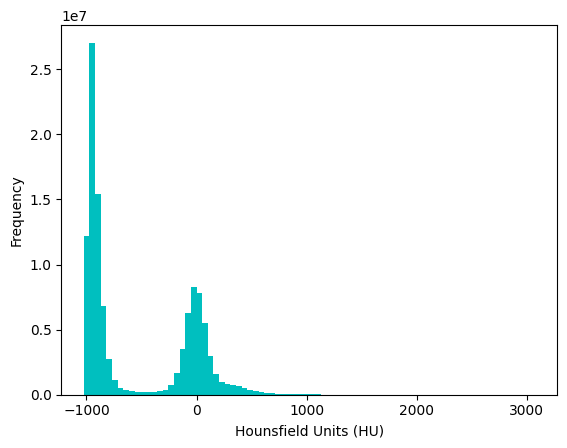

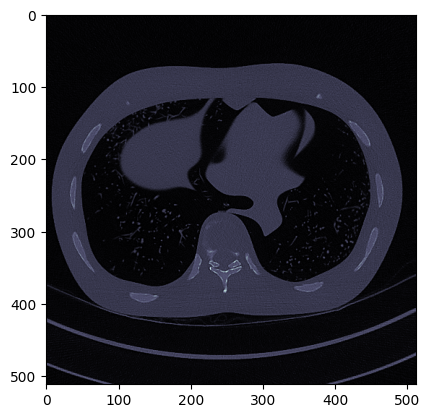

In [5]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import os
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
from scipy.ndimage.interpolation import rotate

# create a function to load the files
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    return slices

# create a function to get the pixel values
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)

# load the scans
first_patient = load_scan(data_dir)
first_patient_pixels = get_pixels_hu(first_patient)

# visualize
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.bone)
plt.show()


In [5]:
# import os
# import pydicom
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import measure
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# def load_scan(path):
#     slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path)]
#     slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
#     return slices

# def get_pixels_hu(slices):
#     image = np.stack([s.pixel_array for s in slices])
#     image = image.astype(np.int16)
#     image[image == -2000] = 0
#     intercept = slices[0].RescaleIntercept
#     slope = slices[0].RescaleSlope
#     if slope != 1:
#         image = slope * image.astype(np.float64)
#         image = image.astype(np.int16)
#     image += np.int16(intercept)
#     return np.array(image, dtype=np.int16)

# def plot_3d(image, threshold=-300):
#     p = image.transpose(2,1,0)
#     verts, faces, _, _ = measure.marching_cubes(p, threshold)
#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')
#     mesh = Poly3DCollection(verts[faces], alpha=0.70)
#     face_color = [0.45, 0.45, 0.75]
#     mesh.set_facecolor(face_color)
#     ax.add_collection3d(mesh)
#     ax.set_xlim(0, p.shape[0])
#     ax.set_ylim(0, p.shape[1])
#     ax.set_zlim(0, p.shape[2])
#     plt.show()

# # Path to the DICOM directory
# path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"  # Change this to your DICOM directory
# scan = load_scan(path)
# image = get_pixels_hu(scan)

# # Threshold: change this value to segment different parts of the image
# # For example, a threshold of 400 will segment the bones
# plot_3d(image, 400)
